## Modules Used

Modulo responsável pela comunicação com o CoppeliaSim

In [2]:
# Modules used to connect to coppelia
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

Modulos Usados para Nesse trabalho prático

In [3]:
# Other Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import networkx as nx
from copy import deepcopy
from time import sleep, time

## Exemplo

Exemplo de como se conectar no Coppelia

In [7]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

floorHandle = sim.getObject("/heightfield")
_, _, info = sim.getShapeGeomInfo(floorHandle)

sim.stopSimulation()
sleep(1)


In [9]:
print('x, y, z = ', info[:3])

x, y, z =  [40.0, 40.0, 3.984375]


## Funções Auxiliares

#### Codding to calculate the Transformation Matrix

In [326]:
# Function that invert a matrix
def invertMatrix(M):
    return np.linalg.inv(M)

In [327]:
# Get Object Position and Orientation
def getPositionAndOrientation(handle, referenceTo):
    pos = sim.getObjectPosition(handle, referenceTo)
    ori = sim.getObjectOrientation(handle, referenceTo)
    return pos, ori

In [328]:
# Get Rotation Matrix fixed on Z axis
def getRotationMatrixZfixed(theta):
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

In [329]:
# get the transformation from local axis to a reference axis
# the default reference axis is the global/world axis
def getTransformationMatrix(handle, referenceTo=sim.handle_world):
    # Get the object position and orientation
    pos, ori = getPositionAndOrientation(handle, referenceTo)
    # Get the Rotation Matrix
    rotM = getRotationMatrixZfixed(ori[2])
    scale = np.array([0, 0, 0, 1])

    # Create the transformation Matrix
    tranfMatrix = np.column_stack((rotM, pos))
    tranfMatrix = np.row_stack((tranfMatrix, scale))

    return tranfMatrix



In [330]:
# Get the tranfortion from object in reference to another
def getTransformationMatrixObject2Object(sourceObject, desObject,printPlot = False):
    M_S2G = getTransformationMatrix(sourceObject)
    M_G2S = invertMatrix(M_S2G)
    M_D2G = getTransformationMatrix(desObject)

    return M_G2S @ M_D2G

In [331]:
'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -clientId: simulator client id obtained through a successfull connection with the simulator.
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id, sim.simx_opmode_streaming)
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id)

    # print(range_data_signal_id)
    resultCodeRanges = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    # returnCodeAngles, string_angle_data = sim.simxGetStringSignal(angle_data_signal_id, sim.simx_opmode_blocking)
    
    resultCodeAngles = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if resultCodeRanges != None and resultCodeAngles != None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(resultCodeRanges)
        raw_angle_data = sim.unpackFloatTable(resultCodeAngles)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None


## Força de Atração

### Variáveis Usadas

In [332]:
K_att = 0.1 # Constante proporcional usado na força de atração

### Função Responsável por calcular a força de Atração

In [333]:
def attraction_force(position, goal, K=0.1):
    return (K * (goal - position))[:2]

### Teste da Força de atração

Connected to remote API server
robot position:  [ -4.00042948 -12.99999751   0.13863256]
goal position:  [10.         -8.          0.13879307]
força de atração resultante:  [1.40004295 0.49999975]
força de atração resultante (usando transformação):  [ 5.40004295 13.49999975]


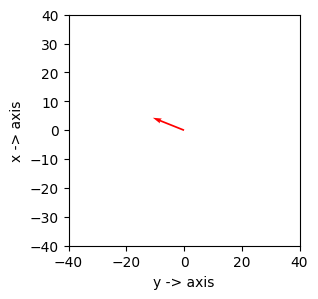

In [334]:
import time
sim.startSimulation()

print ('Connected to remote API server')
    
# Iniciando a simulação
# Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
# e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)     

# Handle para o Goal
goalname = "/Goal"
goalHandle = sim.getObject(goalname)

# Pega a posição do Robo e do goal
robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
goalPosition = np.asarray(sim.getObjectPosition(goalHandle))
print('robot position: ', robotPosition)
print('goal position: ', goalPosition)

f_att = attraction_force(robotPosition, goalPosition, K_att)
print('força de atração resultante: ', f_att)

sleep(2)
sim.stopSimulation()
sleep(1)

# V = np.array([[1,1], [-2,2], [4,-7]])
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point


Tranformation_robot_to_world = getTransformationMatrix(robotHandle)
Tranformation_world_to_robot = invertMatrix(Tranformation_robot_to_world)
Fatt = Tranformation_world_to_robot @ np.asarray([f_att[0], f_att[1], 0, 1])
print('força de atração resultante (usando transformação): ', Fatt[:2])


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Os eixos do coppelia em relação do matplot lib são invertidos
# Coppelia_X = MatplotLib_Y e vice versa
# O eixo Y (eixo X do Matplot) do robo tem uma direção diferente do Matplot lib e portanto multiplicamos o eixo por -1
ax.quiver(*[0, 0], -Fatt[1], Fatt[0], color=['r','b','g'], scale=100)


ax.set_xlabel("y -> axis")
ax.set_ylabel("x -> axis")

ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

plt.show()
    


## Força de Repulsão

### Variáveis Utilizadas

In [335]:
K_rep = 0.0001
gamma = 2
p0 = 2 # Limiar utiliazado

### Função da força de Repulsão

In [336]:
def repulsion_force(laser_data, K, gamma=2, threshold=2):
    # Pega somente os dados que atendem a condição de terem uma distancia menor que o limiar
    filter = laser_data[:, 1] < threshold
    data = laser_data[filter]
    
    # separa os dados em angulos e distancias
    distaces = data[:, 1]
    angles = data[:, 0]

    # Calcula a parte escalar da formulada força de recursão
    escalar = K / (distaces**2)
    escalar *= (1/distaces) - 1/threshold

    # Calcula a parte vetorial da formula da força de repulsão
    # Eixo x
    axis_x = distaces * np.cos(angles)
    # Eixo y
    axis_y = distaces * np.sin(angles)
    
    delta_x = sum(escalar * (axis_x / distaces))
    delta_y = sum(escalar * (axis_y / distaces))
    
    # Multiplico por -1, para calcular
    return np.asarray([-delta_x, -delta_y])



### Teste da força de repulsão

In [337]:
sim.startSimulation()

print ('Connected to remote API server')
    
# Iniciando a simulação
# Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
# e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)   

# Handle para o Goal
goalname = "/Goal"
goalHandle = sim.getObject(goalname)

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')  

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)  

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas
range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

####################  Teste Está sendo realizado aqui ######################

# Pega a posição do Robo e do goal
robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
goalPosition = np.asarray(sim.getObjectPosition(goalHandle))
print('robot position: ', robotPosition)
print('goal position: ', goalPosition)

# Handle para o Laser
lasername = "/Pioneer_p3dx/fastHokuyo"
laserHandle = sim.getObject(lasername)

tranformation_laser_to_robot = getTransformationMatrix(laserHandle, robotHandle)

f_rep = repulsion_force(laser_data, K_rep, gamma, p0)
f_rep = tranformation_laser_to_robot @ np.asarray([f_rep[0], f_rep[1], 0, 1])
f_rep = f_rep[:2]

sleep(3)
sim.stopSimulation()
sleep(1)
    
print ('Program ended')

Connected to remote API server
robot position:  [ -4.00036861 -12.99998698   0.13866851]
goal position:  [10.         -8.          0.13879307]
Program ended


[0.0000000e+00 8.8817842e-16]


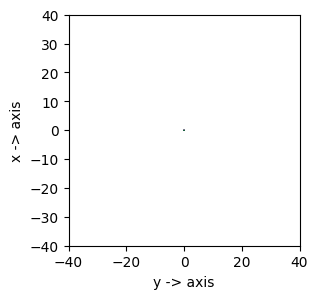

In [338]:
print(f_rep)
fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Os eixos do coppelia em relação do matplot lib são invertidos
# Coppelia_X = MatplotLib_Y e vice versa
# O eixo Y (eixo X do Matplot) do robo tem uma direção diferente do Matplot lib e portanto multiplicamos o eixo por -1
plt.quiver(*origin, -f_rep[1], f_rep[0], color=['r','b','g'], scale=100)

ax.set_xlabel("y -> axis")
ax.set_ylabel("x -> axis")

ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

plt.show()

### Vetor de Força Resultante

Função que calcula tanto o vetor de força de atração quanto o vetor de força de repulsão

In [344]:
def resultant_force(robotHandle, goalHandle, laserRangeDataHandle, laserAngleDataHandle):
    # Pega a posição do Robo e do goal
    robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
    goalPosition = np.asarray(sim.getObjectPosition(goalHandle))

    ####################  Calcula a força de Repulsão   ######################
    # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
    # Em loop até garantir que as leituras serão válidas
    range_data = None
    while range_data == None:
        range_data = sim.getStringSignal(laser_range_data)
        sim.step()

    # Prosseguindo com as leituras
    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    ### Variáveis Globais: K_rep, gamma, p0
    f_rep = repulsion_force(laser_data, K_rep, gamma, p0)

    #################### Calcula a força de atração ###################

    ### Calcula a matrix de tranformação
    ### Que convert um ponto do referencial do mundo para o referencial do robô
    Tranformation_robot_to_world = getTransformationMatrix(robotHandle)
    Tranformation_world_to_robot = invertMatrix(Tranformation_robot_to_world)

    ### K_att -> Variavel Global
    Fatt = attraction_force(robotPosition, goalPosition, K_att)

    # Transforma o vetor de atração para o referencial do robo
    Fatt = Tranformation_world_to_robot @ np.asarray([Fatt[0], Fatt[1], 0, 0])
    f_att = Fatt[:2]

    print('att: ', f_att)
    print('rep: ', f_rep)

    return f_att + f_rep



### Controlador

In [345]:
def controlador(dx, dy, robotOrientation):

    # Variáveis de proporcionalidade  
    KPr = 0.5
    KPt = 0.5

    # # Variáveis derivativas
    # KDr = 2
    # KDt = 0.5

    # Calcula as velocidades
    # Velocidade Linear Proporcional
    # uPr = dx*np.cos(robotOrientation) + dy*np.sin(robotOrientation)
    # uPr *= KPr
    uPr = (dx + dy) * KPr

    # # Velocidade Linear Derivada
    # uDr = dx_D*np.cos(robotOrientation) + dy_D*np.sin(robotOrientation)
    # uDr *= KDr

    # Velocidade Angular Proporcional 
    # uPt = (np.arctan2(dy,dx) - robotOrientation)
    # uPt *= KPt
    uPt = np.arctan2(dy,dx) * KPt
    # Explicar pq eu multipliquei por -1
    uPt *= -1
    # print(uPt)

    # # Velocidade Angular Derivada
    # uKt = np.arctan2(dy_D,dx_D) - robotOrientation
    # uKt *= KDt
    
    # v -> velocidade Linear
    # w -> Velocidade Angular
    v = uPr #+ uDr
    w = uPt #+ uKt

    # Limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw) 
            
    # Objetivo: quero que o robô ajuste primeiro a sua posição em relação ao objetivo 
    # E dps se movimente para ele
    # if(w > np.deg2rad() or w < np.deg2rad(315) ) and rho > 1)

    # if (w > np.deg2rad(10) and w < np.deg2rad(45) ) and rho > 1:
    #     v = 0
    # if (w < np.deg2rad(-10) and w > np.deg2rad(-45) ) and rho > 1:
    #     v = 0
        

    vr = ((2.0*v) + (w*L))/(2.0*r)
    vl = ((2.0*v) - (w*L))/(2.0*r)

    return vr, vl

In [341]:
# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

### Variáveis Utilizadas

In [342]:
K_rep = 0.01
gamma = 2
p0 = 2 # Limiar utiliazado

In [346]:
sleep(3)

sim.startSimulation()

print ('Connected to remote API server')
    
# Iniciando a simulação
# Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
# e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)    

# Handle para o Goal
goalname = "/Goal"
goalHandle = sim.getObject(goalname)

# Handle para o Laser
lasername = "/Pioneer_p3dx/fastHokuyo"
laserHandle = sim.getObject(lasername)

# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas

range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    # sim.step() responsável por sincronizar com a emulação
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

#raise SystemExit()

# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros

sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)   

startTime=time.time()
lastTime = startTime
t = 0
while t < 40:
    
    now = time.time()
    dt = now - lastTime

    dx, dy = resultant_force(robotHandle, goalHandle, laser_range_data, laser_angle_data)
    print(dx, dy)
    robotOrientation = sim.getObjectOrientation(robotHandle)
    
    vr, vl = controlador(dx, dy, robotOrientation[2])
    
    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, vr)
    sim.setJointTargetVelocity(r_wheel, vl)        

    t = t + dt  
    lastTime = now

    break

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)        
    
sim.stopSimulation()

print ('Program ended')

Connected to remote API server
att:  [1.40004281 0.49997835]
rep:  [0 0]
1.400042813048592 0.4999783549572036
Program ended
